<a href="https://colab.research.google.com/github/charlie-horn/aer1217-project/blob/main/RRT_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

In [ ]:
# IGNORE
fig = plt.figure()
plt.axis([0,9,0,9])

circles = []
for i in range(len(obstacle_locations)):
  circle = plt.Circle((obstacle_locations[i][0], obstacle_locations[i][1]), radius=obstacle_radii[i])
  circles.append(circle)

for i in range(len(obstacle_locations)):
  plt.gca().add_patch(circles[i])

def buildChart(i = int):
  p = plt.plot(pts_x[:i], pts_y[:i], 'ro-')
  return p
plt.axis('equal')

import matplotlib.animation as ani
animator = ani.FuncAnimation(fig, buildChart, interval = 200)
from IPython.display import HTML
HTML(animator.to_html5_video())

In [63]:
class Environment:
  def __init__(self, start, goal):
    self.bounds = [9, 9]                         # map bounds [x, y]
    self.obstacle_locations = [[8, 3],           # center coordinates of obstacles
                              [2, 4],
                              [5, 5]]

    self.obstacle_radii = [1, 1, 1.25]           # radius corresponding to each obstacle
    self.start = start                           # start location
    self.goal = goal                             # goal location

class Node:
  def __init__(self, lenGraph, location, parent, children, incurredCost, isStart, isGoal):
    self.id = 1
    if not isStart:
      self.id = lenGraph + 1
    self.location = location
    self.parent = parent
    self.children = children
    self.incurred_cost = incurredCost
    self.isStart = isStart
    self.isGoal = isGoal

class RRT_star:
  def __init__(self, x_start, x_goal, max_step_len, max_iter):
    self.x_start = x_start                         # start location (type: point/tuple)
    self.x_goal = x_goal                           # goal location (type: point/tuple)
    self.max_step_len = max_step_len               # truncate if sampled point beyond this distance (type: float)
    self.max_iter = max_iter                       # how many iterations to run the planner (type: integer)
    self.search_rad = 2.0                          # maximum search radius to get list of proximal points (type: float)
    self.goal_path = []                            # lowest cost path so far (type: list of node ids)
    self.env = Environment(x_start, x_goal)        # initialize environment (type: Environment class)
    self.goal_state_thresh = 0.60                  # how far away should a point be to be considered goal (type: float)
    self.goal_reached = False                      # global variable to sample the goal state only once (type: boolean)

    node0 = Node(0, x_start, 1, [], 0, True, False)
    self.graph = [node0]                           # initialize graph of nodes and edges (type: list of nodes)

  def plan(self):
    for iter in range(self.max_iter):
      #print("Iteration: ", iter)
      # sample a random point (truncated)
      X_new = self.samplePoint()
      X_nearest = self.getNearestNode(X_new)
      path_nearest = [X_nearest.location, X_new]

      # check for collision of point/path
      if self.checkInvalidPoint(X_new):
        continue
      else: 
        if self.checkInvalidPath(path_nearest):
          continue

      # get cost to nearest neighbor
      cost_Xnew = self.distPointToGraph2(X_new, X_nearest)
      total_cost_Xnew = self.getTotalCost(X_nearest) + cost_Xnew

      # check if goal
      isGoal = False
      if self.goalState(X_new):
        isGoal = True
        self.goal_reached = True
        print("Goal Reached") 

      # create node from new point with parent as nearest node and no children
      node = Node(len(self.graph), X_new, X_nearest.id, [], cost_Xnew, False, isGoal)
      _, cheapest_node_ind = self.queryGraph(X_nearest.id)
      self.graph[cheapest_node_ind].children.append(node.id)

      # check if a cheaper path exists to node
      X_neighbors = self.getAllNeighbors(X_new)
      for i in range(len(X_neighbors)):
        cost_of_neighbor = self.getTotalCost(X_neighbors[i])
        cost_to_neighbor = self.distPointToGraph2(X_new, X_neighbors[i])
        total_cost = cost_of_neighbor + cost_to_neighbor
        if total_cost < total_cost_Xnew:
          total_cost_Xnew = total_cost
          node.parent = X_neighbors[i].id
          node.incurred_cost = cost_to_neighbor
          self.graph[cheapest_node_ind].children.remove(node.id)
          _, cheapest_node_ind = self.queryGraph(X_neighbors[i].id)
          self.graph[cheapest_node_ind].children.append(node.id)
      self.graph.append(node)

      # excluding parent, check if rewiring neighbors makes sense
      for x_ in X_neighbors:
        x_test = x_
        # get cost of wiring to X_new 
        if (x_test.id is not node.parent) or (x_test.id == node.parent):
          cost_of_path = self.getTotalCost(x_test)
          cost_new_path = self.getTotalCost(node) + self.distPointToGraph2(x_test.location, node)
          if cost_new_path < cost_of_path:
            _, x_test_ind = self.queryGraph(x_test.id)
            _,old_parent_ind = self.queryGraph(x_test.parent)
            self.graph[x_test_ind].parent = node.id
            node.children.append(x_test.id)
            self.graph[old_parent_ind].children.remove(x_test.id)
            self.graph[x_test_ind].incurred_cost = self.distPointToGraph2(x_test.location, node)
      self.graph.remove(self.graph[len(self.graph)-1])
      self.graph.append(node)

      self.goal_path.clear()
      for node in self.graph:
          if node.isGoal:
            self.goal_path.append(node)

      if len(self.goal_path):
        node = self.goal_path[len(self.goal_path)-1]
        isStart = node.isStart
        while not isStart:
          parent,_ = self.queryGraph(node.parent)
          self.goal_path.append(parent)
          node = parent 
          isStart = node.isStart

  def samplePoint(self):
      # sample with uniform random sampling over the workspace
      x_rand = random.uniform(0.0001, self.env.bounds[0]-0.0001)
      y_rand = random.uniform(0.0001, self.env.bounds[1]-0.0001)
      rand_point = (x_rand, y_rand)

      # check if sample is in goal
      isGoal = self.goalState(rand_point)
      if isGoal:
        rand_point = self.x_goal

      if self.goal_reached:
        while isGoal:
          x_rand = random.uniform(0.0001, self.env.bounds[0]-0.0001)
          y_rand = random.uniform(0.0001, self.env.bounds[1]-0.0001)
          rand_point = (x_rand, y_rand)
          isGoal = self.goalState(rand_point)

      # check if random point is beyond the maximum radius from the nearest neighbor
      nearest_node = self.getNearestNode(rand_point)
      dist_to_nn = self.distPointToGraph2(rand_point, nearest_node)
      if dist_to_nn > self.max_step_len:
        delta_x = x_rand - nearest_node.location[0]
        delta_y = y_rand - nearest_node.location[1]
        x_rand = nearest_node.location[0] + (delta_x/dist_to_nn)*self.max_step_len
        y_rand = nearest_node.location[1] + (delta_y/dist_to_nn)*self.max_step_len

      return (x_rand, y_rand)

  def checkInvalidPoint(self, point):
      # get euclidean dist between point and center of each obstacle and compare to radius
      invalidPoint = False
      for i in range(len(self.env.obstacle_locations)):
        arg = np.array(self.env.obstacle_locations[i]) - np.array(point)
        dist = np.linalg.norm(np.array(self.env.obstacle_locations[i]) - np.array(point))
        if dist <= self.env.obstacle_radii[i]:
          invalidPoint = True
      return invalidPoint

  def getNearestNode(self, point):
      nearest_node = self.graph[0]
      dist = self.distPointToGraph(point, 0)
      for i in range(len(self.graph)):
        dist_test = self.distPointToGraph(point, i)
        if dist_test < dist:
          dist = dist_test
          nearest_node = self.graph[i]
      return nearest_node

  def distPointToGraph(self, point, graph_index):
      return np.linalg.norm(np.array(self.graph[graph_index].location) - np.array(point))

  def distPointToGraph2(self, point, node):
      return np.linalg.norm(np.array(node.location) - np.array(point))

  def checkInvalidPath(self, path):
      invalidPath = False
      for i in range(len(self.env.obstacle_locations)):
        loc = self.env.obstacle_locations[i]

        p1 = path[0]
        p2 = path[1]

        m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
        c1 = p1[1] - m1*p1[0]
        m2 = -1/m1
        c2 =  loc[1] - m2*loc[0]

        x_intersect = (c2 - c1)/(m1 - m2)
        y_intersect = m2 * x_intersect + c2

        # get order of points
        p1p2x = False
        p1p2y = False
        p2p1x = False
        p2p1y = False

        if p1[0] > p2[0]:
          p1p2x = True
        else:
          p2p1x = True
        if p1[1] > p2[1]:
          p1p2y = True
        else:
          p2p1y = True

        inRange = False
        # case 1: x1 > x2, y1 > y2
        if p1p2x and p1p2y:
          if ((x_intersect > p2[0]) and (x_intersect < p1[0])) and ((y_intersect > p2[1]) and (y_intersect < p1[1])):
            inRange = True
        # case 2: x1 > x2, y2 > y1
        elif p1p2x and p2p1y:
          if ((x_intersect > p2[0]) and (x_intersect < p1[0])) and ((y_intersect > p1[1]) and (y_intersect < p2[1])):
            inRange = True
        # case 3: x2 > x1, y1 > y2
        elif p2p1x and p1p2y:
          if ((x_intersect > p1[0]) and (x_intersect < p2[0])) and ((y_intersect > p2[1]) and (y_intersect < p1[1])):
            inRange = True
        # case 4: x2 > x1, y2 > y1
        else:
          if ((x_intersect > p1[0]) and (x_intersect < p2[0]) and (y_intersect > p1[1]) and (y_intersect < p2[1])):
            inRange = True

        x_range = 100000
        if inRange:
          # get perpendicular distance between center of circle and intersect
          arr1 = np.array(loc)
          arr2 = np.array([x_intersect, y_intersect])
          vec = arr2 - arr1
          x_range = np.linalg.norm(vec)
        
        if x_range < self.env.obstacle_radii[i]:
          invalidPath = True
          break
      return invalidPath

  def goalState(self, point):
      # if distance of point from goal state < thresh then return true
      if np.linalg.norm(np.array(point) - np.array(self.x_goal)) < self.goal_state_thresh:
        return True
      else:
        return False

  def getAllNeighbors(self, point):
      # search graph for nodes within a certain radius from point
      neighbors = []
      for i in range(len(self.graph)):
        node = self.graph[i]
        dist = self.distPointToGraph2(point, node)
        if dist < self.search_rad:
          path = [node.location, point]
          if not self.checkInvalidPath(path):
            neighbors.append(node)
      return neighbors

  def queryGraph(self, node_id):
      # return a node given an id
      for ind in range(len(self.graph)):
        if self.graph[ind].id == node_id:
          return self.graph[ind], ind

  def getTotalCost(self, query_node):
      # get total cost from node all the way back to start
      node = query_node
      total_cost = node.incurred_cost
      isStart = False
      while not isStart:
        parent_node_id = node.parent
        node,_ = self.queryGraph(parent_node_id)
        total_cost = total_cost + node.incurred_cost
        isStart = node.isStart
      return total_cost

  def visualize(self):
      fig = plt.figure()
      plt.axis([0, 9, 0, 9])

      circles = []
      for i in range(len(self.env.obstacle_locations)):
        circle = plt.Circle((self.env.obstacle_locations[i][0], self.env.obstacle_locations[i][1]), radius=self.env.obstacle_radii[i])
        circles.append(circle)

      for i in range(len(self.env.obstacle_locations)):
        plt.gca().add_patch(circles[i])

      for node in self.graph:
        pts_x = []
        pts_y = []
        parent, _ = self.queryGraph(node.parent)
        loc_parent = parent.location
        loc_node = node.location
        pts_x.append(loc_parent[0])
        pts_y.append(loc_parent[1])
        pts_x.append(loc_node[0])
        pts_y.append(loc_node[1])
        plt.axis('scaled')
        if node in self.goal_path:
          plt.plot(pts_x, pts_y, 'ro-')
        else:
          plt.plot(pts_x, pts_y, 'bo-')

  def visualize_goal(self):
      fig = plt.figure()
      plt.axis([0, 9, 0, 9])

      circles = []
      for i in range(len(self.env.obstacle_locations)):
        circle = plt.Circle((self.env.obstacle_locations[i][0], self.env.obstacle_locations[i][1]), radius=self.env.obstacle_radii[i])
        circles.append(circle)

      for i in range(len(self.env.obstacle_locations)):
        plt.gca().add_patch(circles[i])

      for node in self.goal_path:
        pts_x = []
        pts_y = []
        parent, _ = self.queryGraph(node.parent)
        loc_parent = parent.location
        loc_node = node.location
        pts_x.append(loc_parent[0])
        pts_y.append(loc_parent[1])
        pts_x.append(loc_node[0])
        pts_y.append(loc_node[1])
        plt.axis('scaled')
        plt.plot(pts_x, pts_y, 'ro-')
        
  def convertNodes(self):
    pts_x = []
    pts_y = []
    for node in self.goal_path:
      pts_x.append(node.location[0])
      pts_y.append(node.location[1])
    return pts_x, pts_y

Goal Reached


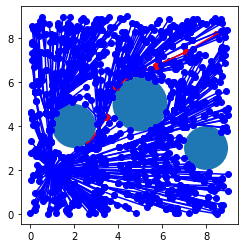

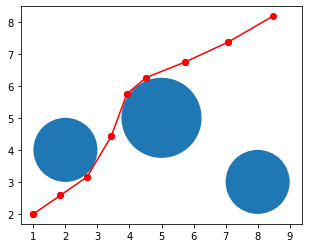

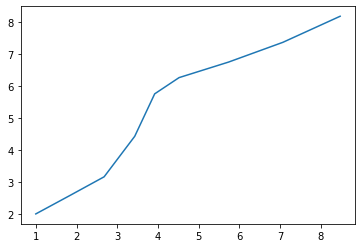

In [62]:
rrt = RRT_star((1,2), (8,8), 2, 1000)       # initialize RRT_star(x_start, x_goal, max_step_length = 2, max_iterations = 1000)
rrt.plan()                                  # this method computes the path as a list of nodes
pts_x, pts_y = rrt.convertNodes()           # this converts the nodes into lists of x and y coordinates

rrt.visualize()
rrt.visualize_goal()

fig2 = plt.figure()
plt.plot(pts_x, pts_y)